In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers import TextVectorization
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook
from collections import Counter

# Data and Pre-processing

In [ ]:
IMAGES_PATH = "/input/flickr8k/Images" # Path to the images
CAPTIONS_PATH = "/input/flickr8k/captions.txt" # Path to the caption
IMAGE_SIZE = (299, 299) # Preferred image dimensions for efficientnet
SEQ_LENGTH = 25 # max length allowed for any sequence
VOCAB_SIZE = 8898 # Vocab size
EMBED_DIM = 512 # Dim for the img  and token embeddings
FF_DIM = 512 ## Dim of the feed-forward network
BATCH_SIZE = 512
EPOCHS = 30 # max epochs

In [ ]:
# Loads captions (text) data and maps them to corresponding images.
def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()[1:] #skip header
        caption_mapping = {} # {img_file_name: [captions]}
        text_data = [] # captions vovcab 
        images_to_skip = set() # short or invalid captioned images

        for line in caption_data:
            line = line.rstrip("\n")
            img_name, caption = line.split(",", 1) # split img_name and caption
            img_name = os.path.join(IMAGES_PATH, img_name.strip()) # get full img path
            tokens = caption.strip().split()
            ## Drop captions that are too short or too long
            if len(tokens) < 4 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                caption = "<start> " + caption.strip() + " <end>" # Apending start and an end token for the captions
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

def train_val_split(caption_data, validation_size=0.2, test_size=0.05, shuffle=True):
    """Create train val test split"""
    all_images = list(caption_data.keys())
    
    ## shuffle images
    if shuffle:
        np.random.shuffle(all_images) 
    
    train_keys, validation_keys = train_test_split(all_images, test_size=validation_size, random_state=42)
    validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)
    
    training_data = {img_name: caption_data[img_name] for img_name in train_keys}
    validation_data = {img_name: caption_data[img_name] for img_name in validation_keys}
    test_data = {img_name: caption_data[img_name] for img_name in test_keys}
    return training_data, validation_data, test_data

# Loading the dataset
captions_mapping, text_data = load_captions_data(CAPTIONS_PATH)

# Spliting the dataset
train_data, validation_data, test_data = train_val_split(captions_mapping)
print(f"Total number of samples: {len(captions_mapping)}")
print(f"----> Number of training samples: {len(train_data)}")
print(f"----> Number of validation samples: {len(validation_data)}")
print(f"----> Number of test samples: {len(test_data)}")

Total number of samples: 7643
----> Number of training samples: 6114
----> Number of validation samples: 1452
----> Number of test samples: 77


In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~1234567890" # drop alphanumeric/symbols
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Defining the vectorizer text -> int seq for model
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE, # token upper limt
    output_mode="int", # op token idx as int
    output_sequence_length=SEQ_LENGTH, # pad/truncate captions to seq_length
    standardize=custom_standardization) # remove alphanumerics and lower case


vectorization.adapt(text_data) # build vocab using text+data

# Data augmentation for img
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                       layers.RandomRotation(0.2),
                                       layers.RandomContrast(0.3)])

# fix compatibitibily issues with non tf pipelines
text_data = list(map(lambda x: str(custom_standardization(x).numpy())[2:-1], text_data))

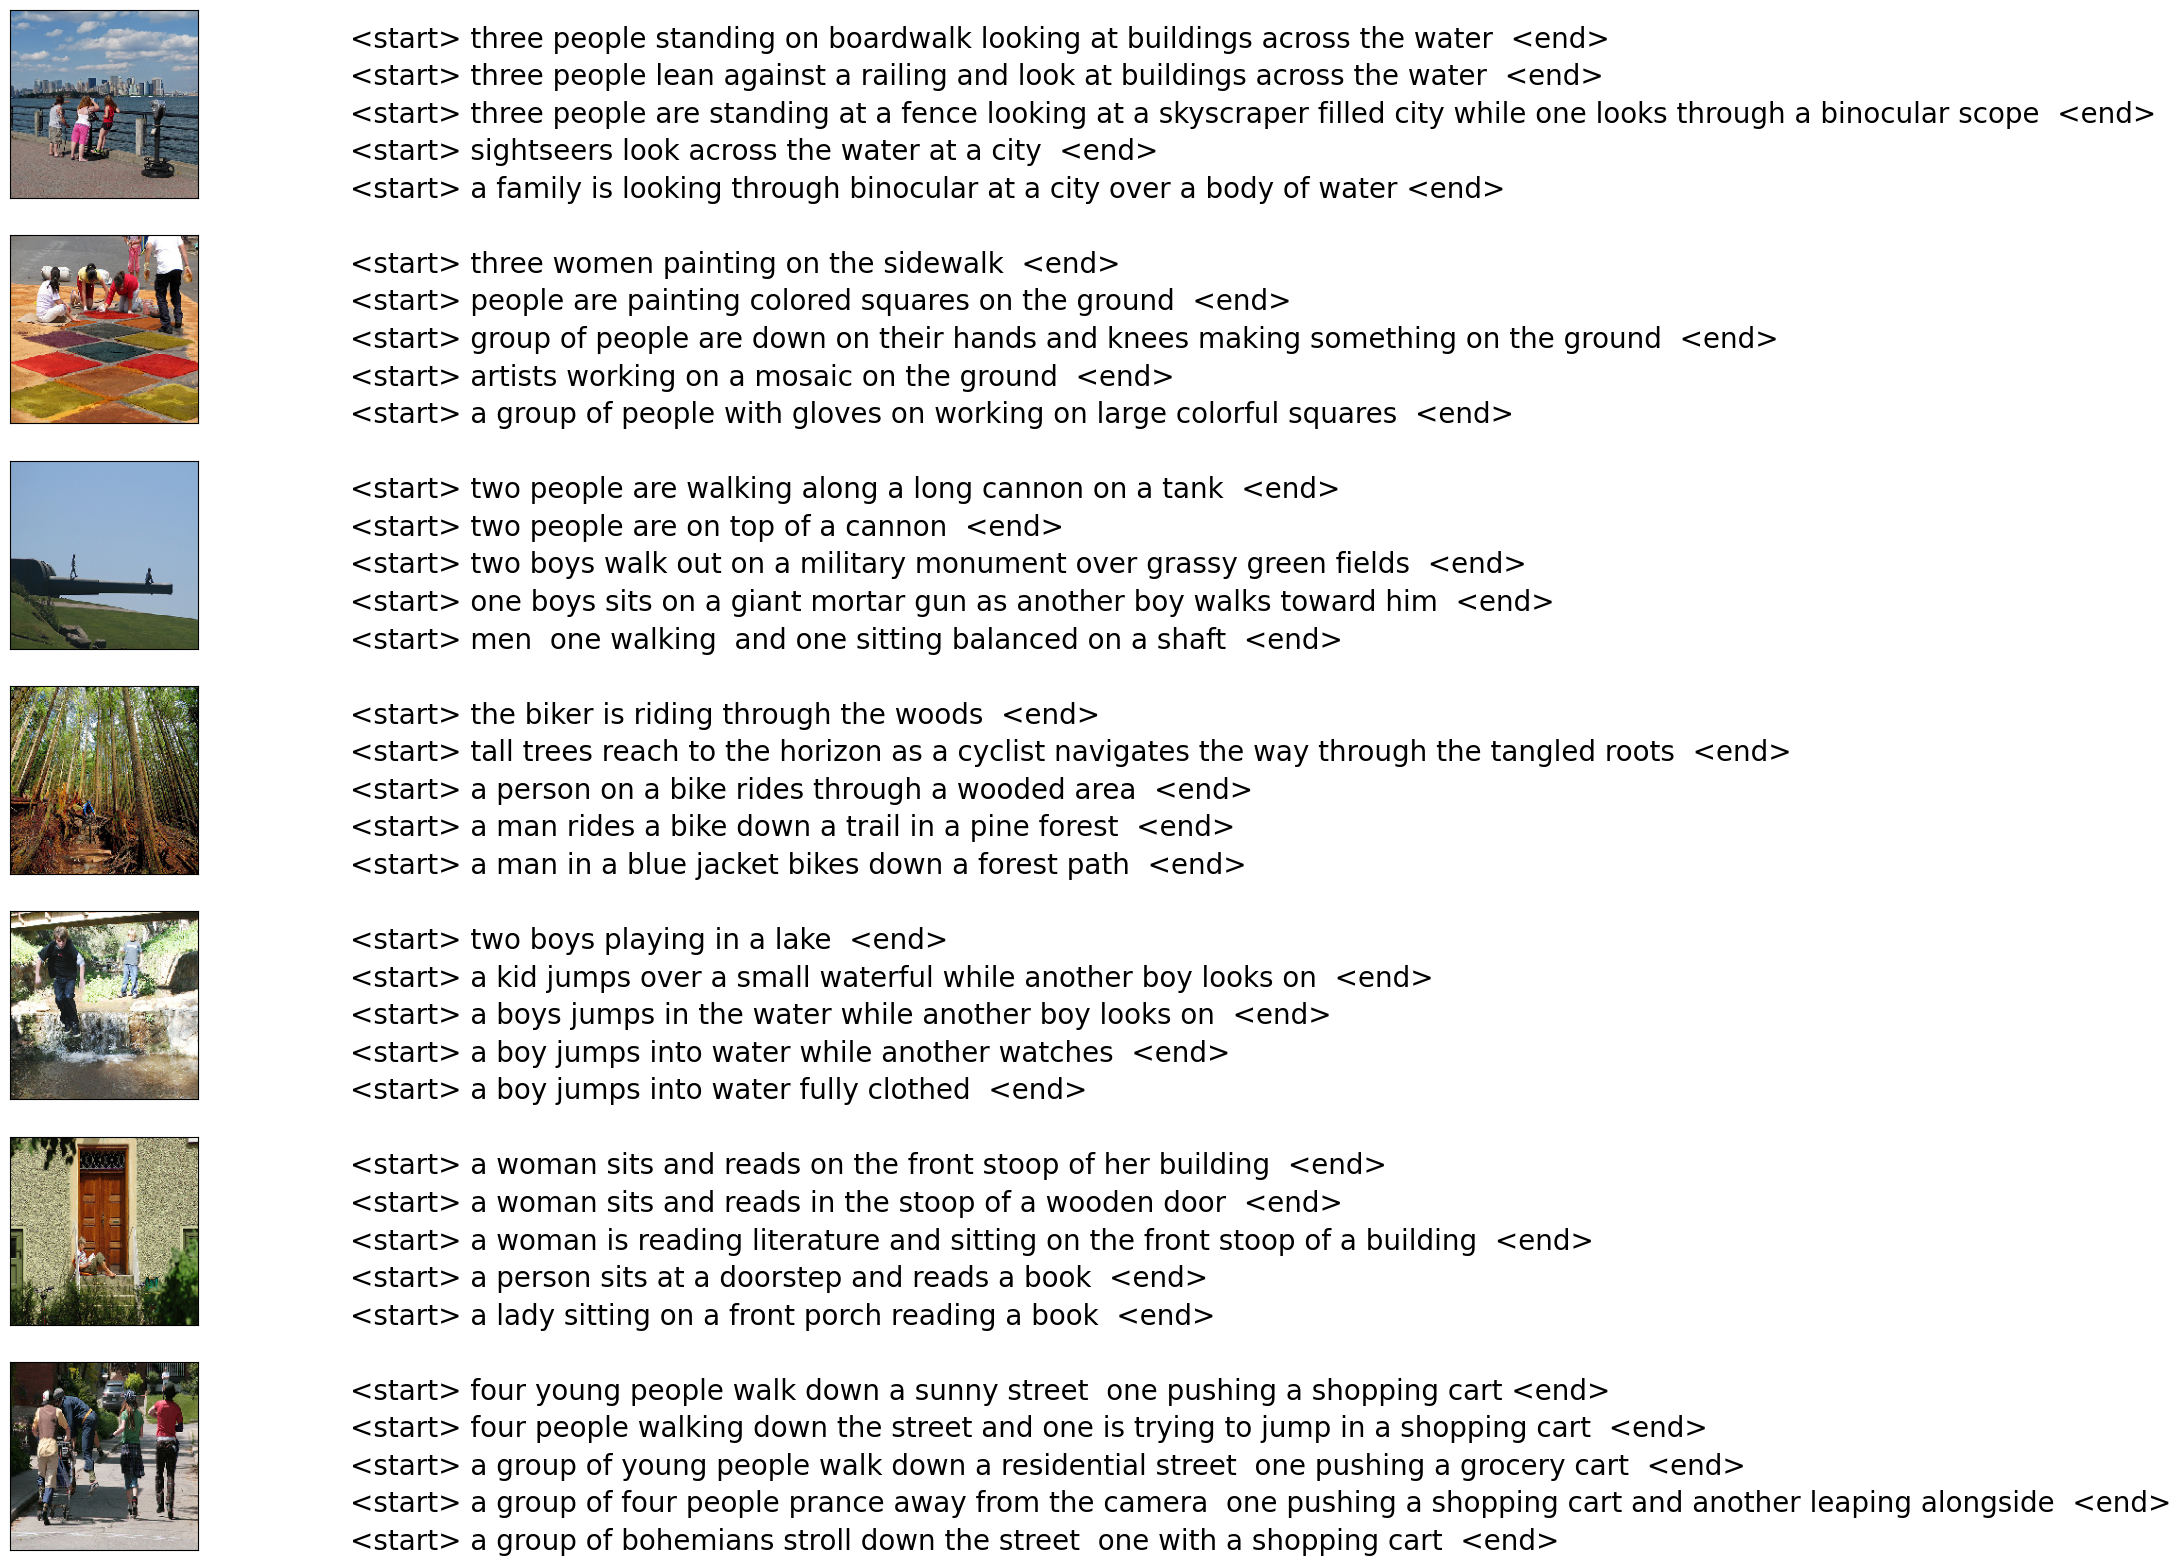

In [ ]:
def show_img_cap(data, num_of_images):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(data.keys())[100:100+num_of_images]:
        captions = list(map(lambda x: str(custom_standardization(x).numpy())[2:-1], data[filename]))
        image_load = load_img(filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
show_img_cap(train_data, 7)

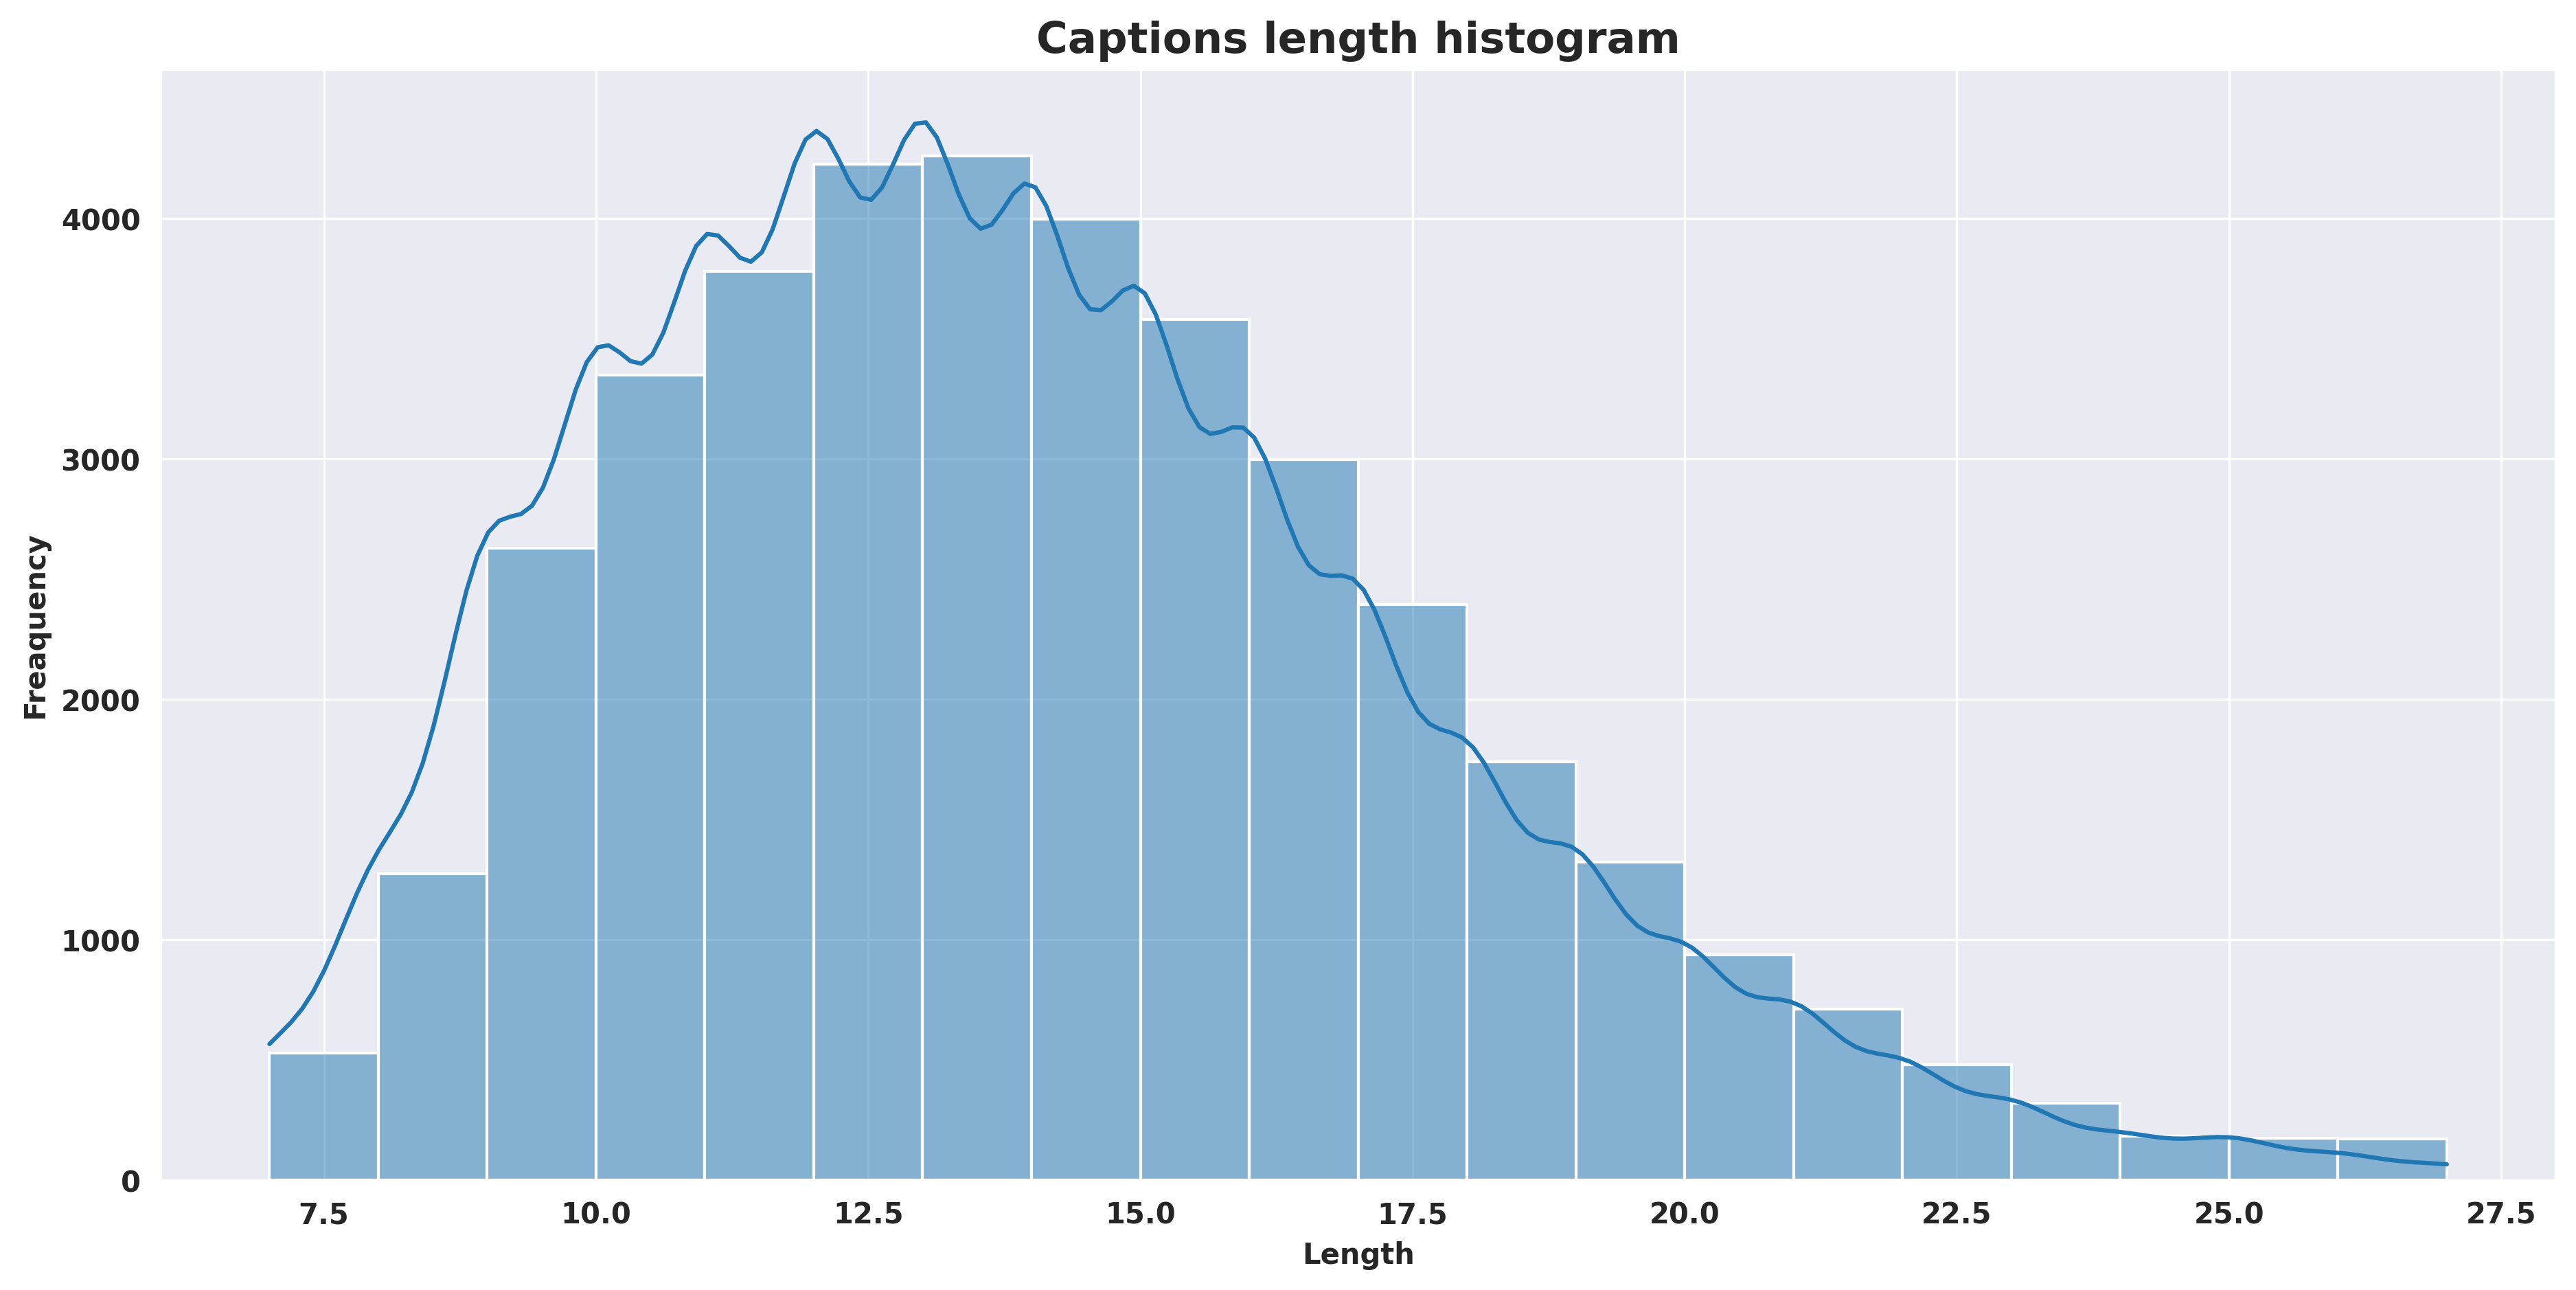

In [ ]:
def captions_len_trend(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_len_trend(text_data)

In [ ]:

def load_sam_embeddings(img_path):
    """load saved sam embedding and average it into a single vector"""
    img_id = tf.strings.split(tf.strings.split(img_path, os.path.sep)[-1], '.')[0]
    sam_path = tf.strings.join(["/kaggle/input/sam-feature-embedding-flickr8k/", img_id, ".npy"])
    sam_emb = tf.py_function(lambda path: np.load(path.numpy()),[sam_path], tf.float32)
    # Average the 5 embeddings to get single vector (shape: 2048)
    return tf.reduce_mean(sam_emb, axis=0)

In [ ]:
def decode_norm(img_path):
    img = tf.io.read_file(img_path)           # Read image file
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG (RGB)
    img = tf.image.resize(img, IMAGE_SIZE)     # Resize to 299x299
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0,1]
    
    # Load SAM embeddings
    sam_emb = load_sam_embeddings(img_path)
    sam_emb.set_shape((2048,))
    
    return {"image": img, "sam_embedding": sam_emb} 
    
def process_input(img_path, captions):
    inputs = decode_norm(img_path)
    return inputs, vectorization(captions) # Process both images and captions in parallel.

# create batches of datasets with pre-fetching enabled for efficiency
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Prefetching step
    return dataset
    
# Making the datasets by passing the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
validation_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))

In [ ]:
def get_cnn_model():
    # Image input
    image_input = layers.Input(shape=(*IMAGE_SIZE, 3), name="image")
    
    # base efficientnet model
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet")(image_input)
    base_model.trainable = False # freeze efficientnet wt
    # Process CNN features
    cnn_output = layers.Reshape((-1, base_model.shape[-1]))(base_model) 
    
    # SAM embedding input
    sam_input = layers.Input(shape=(2048,), name="sam_embedding")
    # reduce SAM features to dense embedding dim
    sam_dense = layers.Dense(EMBED_DIM, activation='relu')(sam_input)
    sam_output = layers.RepeatVector(cnn_output.shape[1])(sam_dense)  # Match time dimension
    # Combine features
    combined = layers.Concatenate(axis=-1)([cnn_output, sam_output])
    combined = layers.Dense(EMBED_DIM)(combined)  # Project back to EMBED_DIM
    
    return keras.models.Model(
        inputs={"image": image_input, "sam_embedding": sam_input},
        outputs=combined,  name="cnn_sam_model" )

In [ ]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim #ip dim
        self.dense_dim = dense_dim # hidden lyr size in ffn
        self.num_heads = num_heads # no of attention heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")
    ## fwd pass
    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs) # normalise ip
        inputs = self.dense_1(inputs) # FF transformation
        attention_output_1 = self.attention_1(query=inputs, value=inputs,  key=inputs,
                                              attention_mask=None,  training=training) # self attention
        out_1 = self.layernorm_2(inputs + attention_output_1) # attention op is added to original img
        return out_1

In [ ]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) #map ip token to dense vec
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim) #maintain token order. maps to embed dim
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32)) # root to scale embedding(for extremely small embedding...0.0009->0.03)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # Positional encoding
        embedded_tokens = self.token_embeddings(inputs) # Input embedding [batch_size, sequence_length, embed_dim]
        embedded_tokens = embedded_tokens * self.embed_scale # Scale embeddings
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # Positional embedding

    def compute_mask(self, inputs, mask=None):
        # true and padding tokens
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.cross_attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(embed_dim=EMBED_DIM,
                                             sequence_length=SEQ_LENGTH,
                                             vocab_size=VOCAB_SIZE,)
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        
        # If the mask is not None, it means that padding tokens are present in the input sequence.
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            # Masking both padding tokens and future tokens
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              attention_mask=combined_mask,
                                              training=training)
        out_1 = self.layernorm_1(inputs + attention_output_1)
        
        # Note that the lengths of the inputs are different and cross-attention handles that.
        cross_attention_output_2 = self.cross_attention_2(query=out_1,
                                              value=encoder_outputs,
                                              key=encoder_outputs,
                                              attention_mask=padding_mask,
                                              training=training)
        out_2 = self.layernorm_2(out_1 + cross_attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        
        preds = self.out(ffn_out)
        return preds
    
    # Masks future tokens
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([tf.expand_dims(batch_size, -1),tf.constant([1, 1], dtype=tf.int32)],axis=0)
        return tf.tile(mask, mult)


In [ ]:
class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

        print()
        print(f'CNN input shape: {cnn_model.input_shape}')
        print(f'CNN output shape: {cnn_model.output_shape}', end='\n'*2)
        print(f'Encoder input ---> Dense layer shape: {cnn_model.output_shape} ---> (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
        print(f'Encoder output shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})', end='\n'*2)
        print(f'Decoder input 1 (Caption) ---> Positional Embedding shape: (None, {SEQ_LENGTH-1}) ---> (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder input 2 (Embedded image features) shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
        print(f'Decoder output (MH Cross-Attention) shape: (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder prediction (Dense layer) shape: (None, {SEQ_LENGTH-1}, {VOCAB_SIZE})')
     

    # Calculates the loss, taking into account a mask to handle padding.
    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    
    # Calculates the accuracy, taking into account a mask to handle padding.
    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    # def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(batch_seq_inp, encoder_out, training=training, mask=mask)
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc
        
    def train_step(self, batch_data):
            batch_inputs, batch_seq = batch_data #image and caption
            batch_img = batch_inputs["image"]
            batch_sam = batch_inputs["sam_embedding"]
            
            batch_loss = 0
            batch_acc = 0
            
            # Apply image augmentation 
            if self.image_aug:
                batch_img = self.image_aug(batch_img)
            
            # Get image embeddings
            img_embed = self.cnn_model({"image": batch_img, "sam_embedding": batch_sam})
            
            for i in range(self.num_captions_per_image):
                with tf.GradientTape() as tape:
                    loss, acc = self._compute_caption_loss_and_acc(
                        img_embed, batch_seq[:, i, :], training=True
                    )
                    batch_loss += loss
                    batch_acc += acc
    
                train_vars = (
                    self.encoder.trainable_variables + self.decoder.trainable_variables
                )
                grads = tape.gradient(loss, train_vars)
                self.optimizer.apply_gradients(zip(grads, train_vars))
    
            batch_acc /= float(self.num_captions_per_image)
            self.loss_tracker.update_state(batch_loss)
            self.acc_tracker.update_state(batch_acc)
    
            return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    
    def test_step(self, batch_data):
        batch_inputs, batch_seq = batch_data
        batch_img = batch_inputs["image"]
        batch_sam = batch_inputs["sam_embedding"]
        
        batch_loss = 0
        batch_acc = 0

        img_embed = self.cnn_model({"image": batch_img, "sam_embedding": batch_sam})
        
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    
    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=3)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation)

16705208/16705208 [==============================] - 0s 0us/step

CNN input shape: {'image': (None, 299, 299, 3), 'sam_embedding': (None, 2048)}
CNN output shape: (None, 100, 512)

Encoder input ---> Dense layer shape: (None, 100, 512) ---> (None, 100, 512)
Encoder output shape: (None, 100, 512)

Decoder input 1 (Caption) ---> Positional Embedding shape: (None, 24) ---> (None, 24, 512)
Decoder input 2 (Embedded image features) shape: (None, 100, 512)
Decoder output (MH Cross-Attention) shape: (None, 24, 512)
Decoder prediction (Dense layer) shape: (None, 24, 10000)


In [ ]:
# Defining the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate)
    
# Creating a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compiling the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Training the model
history = caption_model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/40
12/12 [==============================] - 112s 7s/step - loss: 38.6205 - acc: 0.0624 - val_loss: 28.8462 - val_acc: 0.1935
Epoch 2/40
12/12 [==============================] - 55s 5s/step - loss: 26.2934 - acc: 0.2030 - val_loss: 24.2317 - val_acc: 0.2402
Epoch 3/40
12/12 [==============================] - 55s 5s/step - loss: 23.2846 - acc: 0.2567 - val_loss: 21.9091 - val_acc: 0.2829
Epoch 4/40
12/12 [==============================] - 55s 5s/step - loss: 21.3286 - acc: 0.2946 - val_loss: 20.4486 - val_acc: 0.3137
Epoch 5/40
12/12 [==============================] - 55s 5s/step - loss: 20.0583 - acc: 0.3149 - val_loss: 19.5471 - val_acc: 0.3260
Epoch 6/40
12/12 [==============================] - 55s 5s/step - loss: 19.1851 - acc: 0.3284 - val_loss: 18.8432 - val_acc: 0.3383
Epoch 7/40
12/12 [==============================] - 55s 5s/step - loss: 18.5019 - acc: 0.3377 - val_loss: 18.3401 - val_acc: 0.3451
Epoch 8/40
12/12 [==============================] - 54s 5s/step - loss: 17.

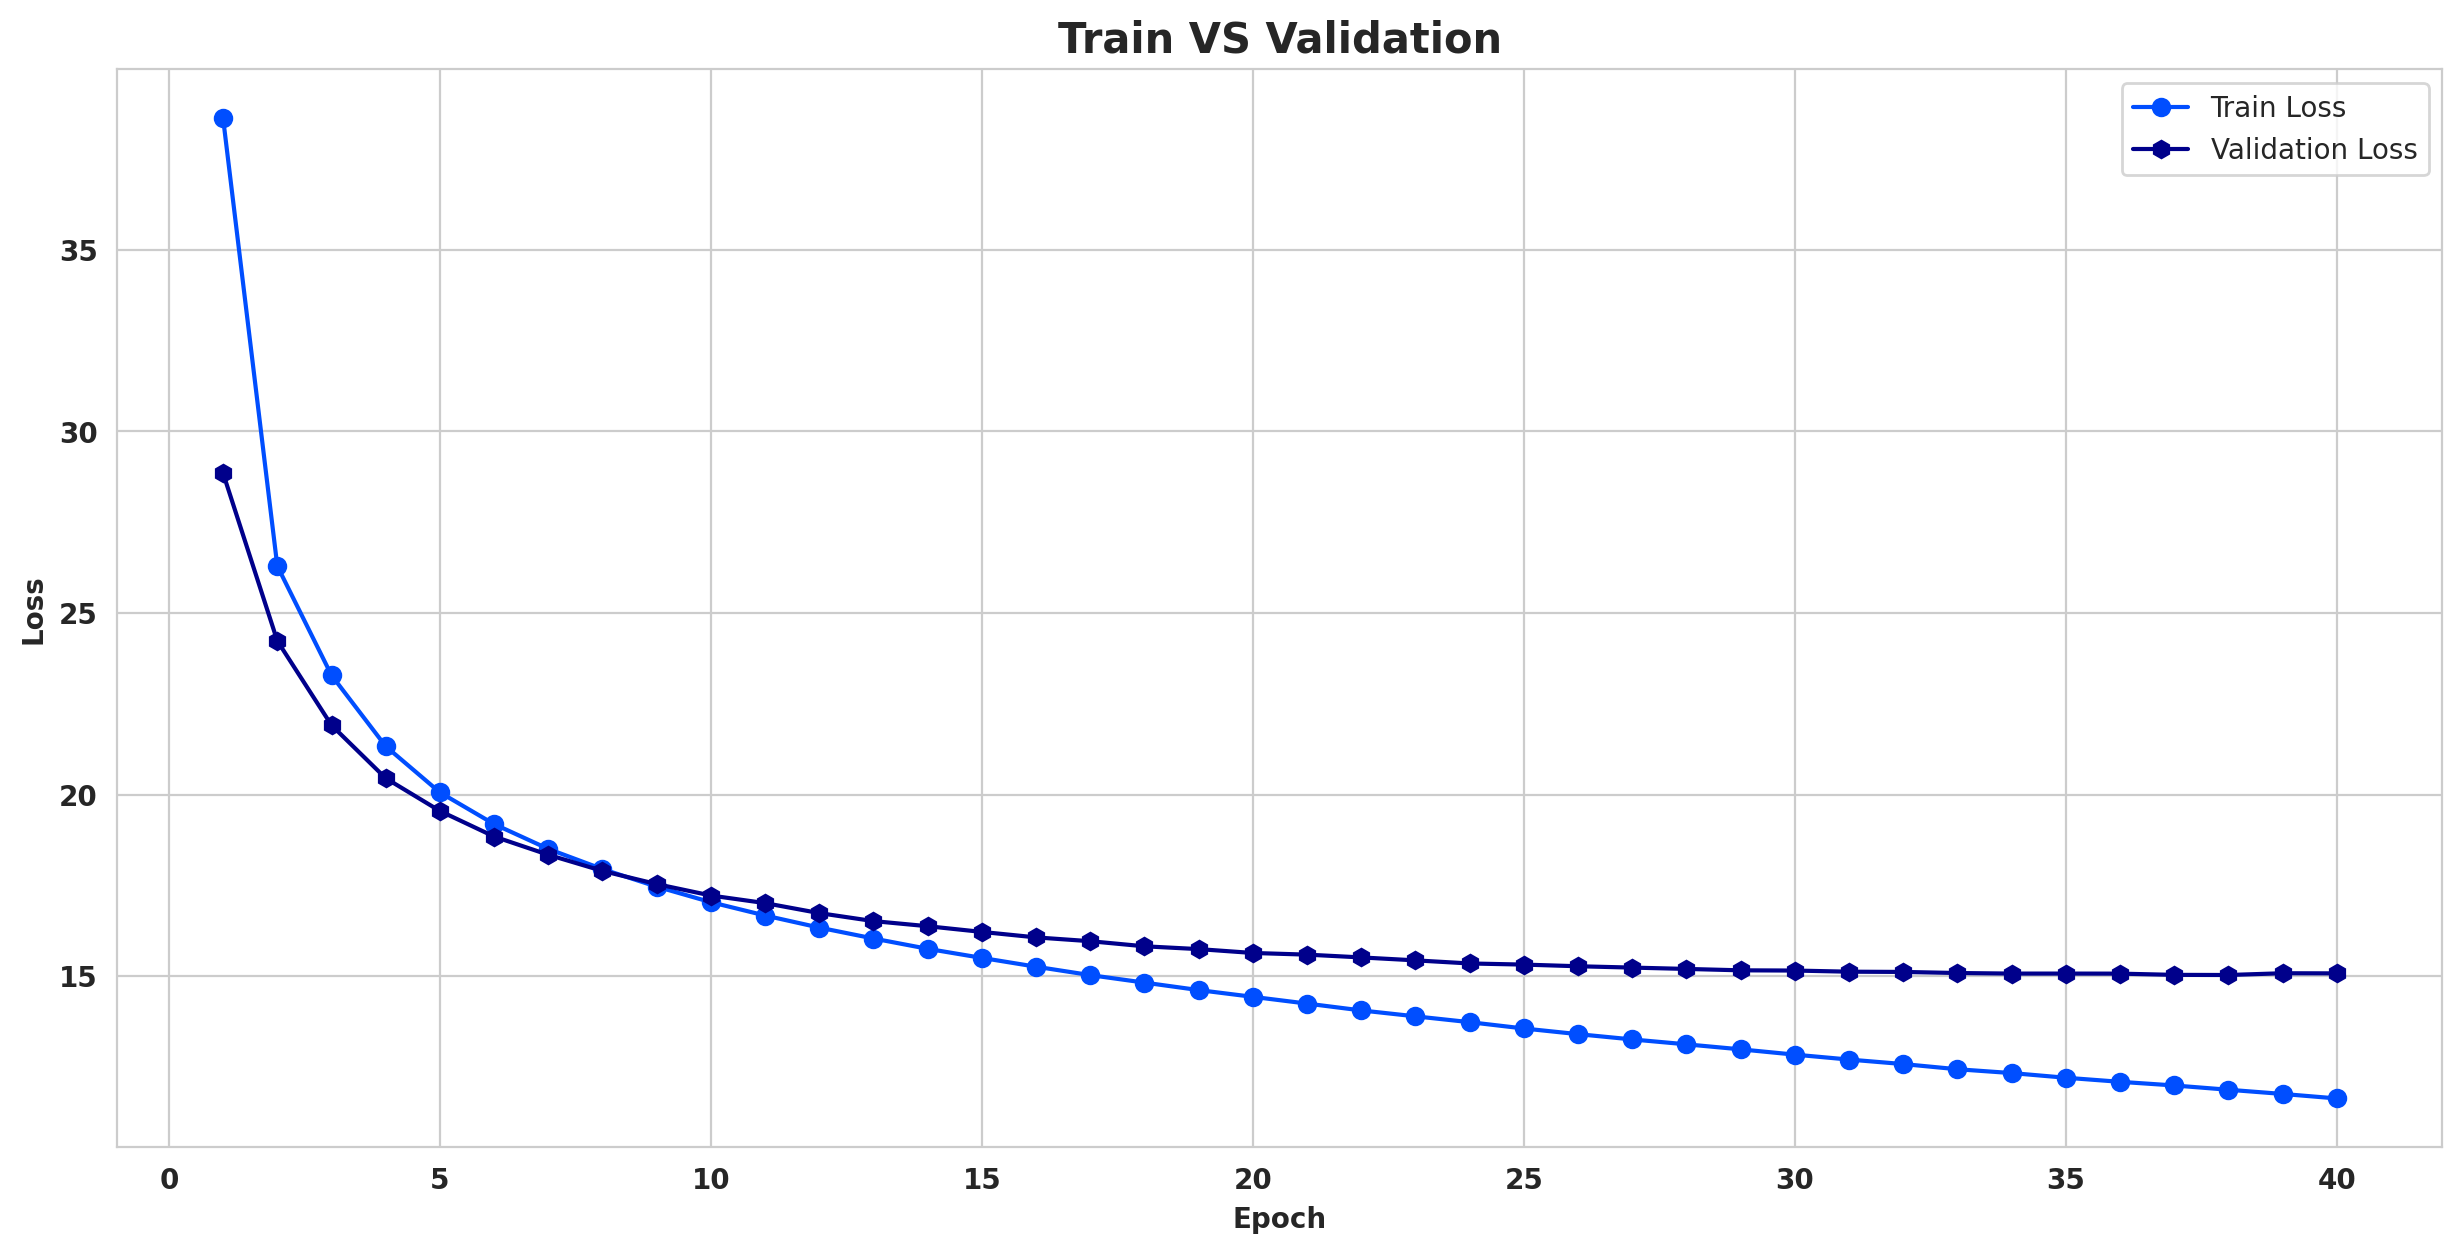

In [12]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#004EFF', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#00008B', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [ ]:
vocab = vectorization.get_vocabulary()
INDEX_TO_WORD = {idx: word for idx, word in enumerate(vocab)}
MAX_DECODED_SENTENCE_LENGTH = SEQ_LENGTH - 1
test_images = list(test_data.keys())

def greedy_algorithm(image):
    # Load and preprocess the image
    inputs = decode_norm(image)
    img = tf.expand_dims(inputs["image"], 0)  # Add batch dimension
    sam_emb = tf.expand_dims(inputs["sam_embedding"], 0)
    
    # Pass inputs to the CNN model
    img_embed = caption_model.cnn_model({"image": img, "sam_embedding": sam_emb})
    
    # Pass the image features to the Transformer encoder
    encoder_out = caption_model.encoder(img_embed, training=False)

    # Initialize the caption with <start> token
    decoded_caption = "<start>"
    for i in range(MAX_DECODED_SENTENCE_LENGTH):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(tokenized_caption, 
                                           encoder_out, 
                                           training=False, 
                                           mask=mask)
        sampled_token_index = tf.argmax(predictions[0, i, :])
        sampled_token = INDEX_TO_WORD[sampled_token_index.numpy()]
        decoded_caption += " " + sampled_token

        if sampled_token == "<end>":
            break

    decoded_caption = decoded_caption.replace("<start>", "").replace("<end>", "").strip()
    return decoded_caption

In [14]:
# Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_data), position=0, leave=True, colour='green')
for image_id in test_data:
    cap = greedy_algorithm(image_id)
    generated_captions[image_id] = cap
    pbar.update(1)
    
pbar.close()

  0%|          | 0/77 [00:00<?, ?it/s]

In [20]:
# Calculates BLEU score of predictions
def BLEU_score(actual, predicted):
    # Standardizing the actual captions
    processed_actual = []
    for i in actual:
        cap = [INDEX_TO_WORD[x] for x in vectorization(i).numpy() if INDEX_TO_WORD[x] != '']
        cap = ' '.join(cap)
        processed_actual.append(cap)
    
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    b1=corpus_bleu(processed_actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(processed_actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(processed_actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(processed_actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return [
        (f'BLEU-4: {round(b4, 5)}'),
        (f'BLEU-3: {round(b3, 5)}'),
        (f'BLEU-2: {round(b2, 5)}'),
        (f'BLEU-1: {round(b1, 5)}'),
        (f'Generated Caption: {predicted[0]}'),
    ]

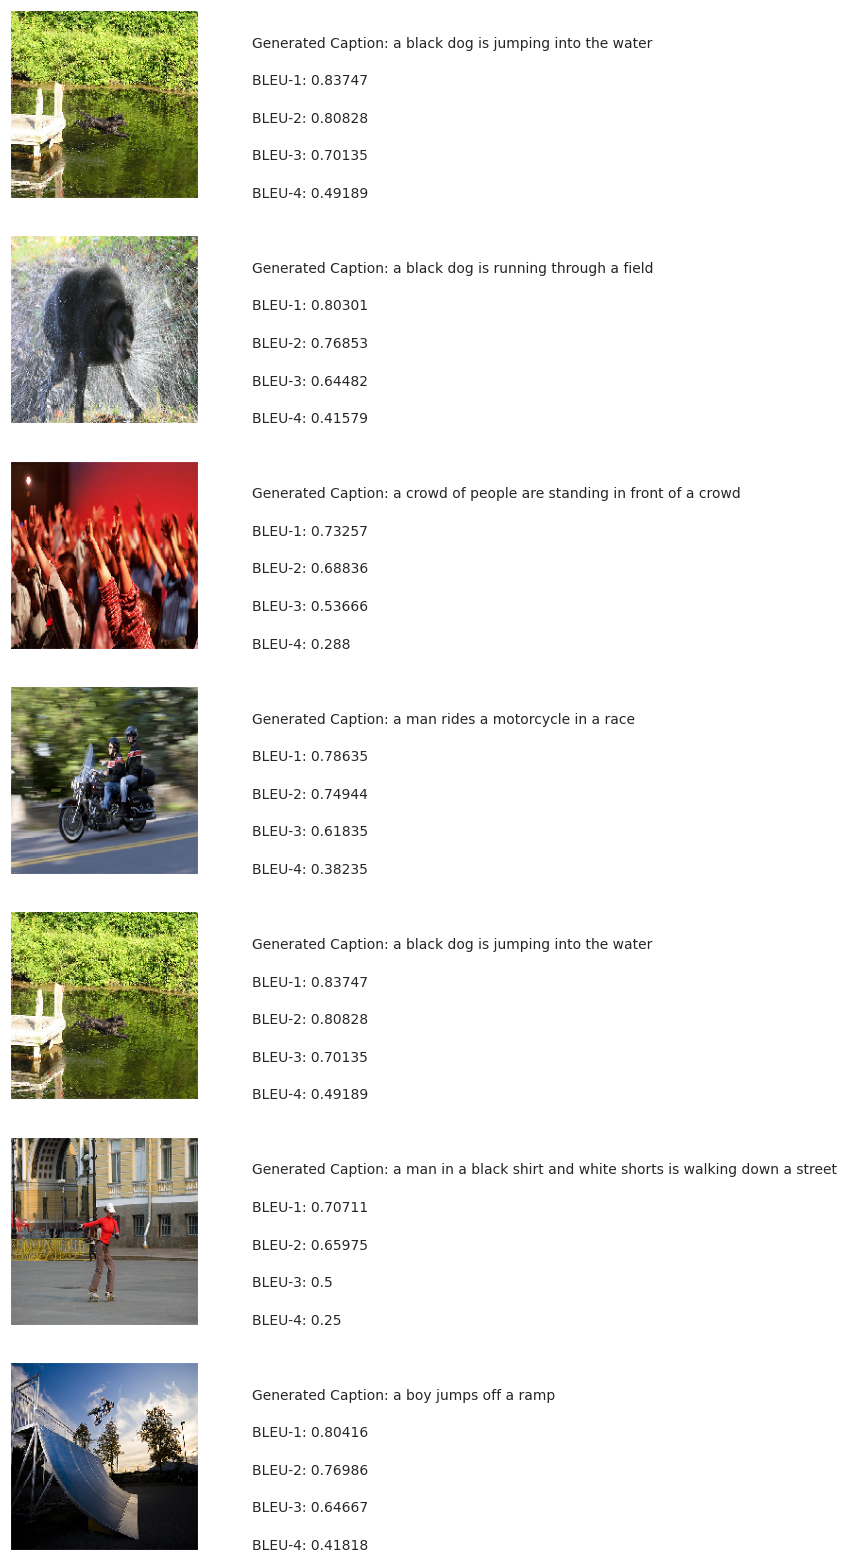

In [25]:
def visualization(data, generated_captions, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    
    count = 1
    fig = plt.figure(figsize=(6,20))    
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("<start> ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" <end>", "") for x in actual_cap] # Removing the end token
        
        caption = generated_captions[filename]
        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [caption]*(len(actual_cap)))
    
        image_load = load_img(filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()
    
visualization(test_data, generated_captions, BLEU_score, 7)

In [ ]:
def calculate_avg_bleu_scores(test_data, generated_captions):
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []
    
    for image_id in test_data:
        # Get actual captions and remove <start> and <end> tokens
        actual_captions = test_data[image_id]
        actual_captions = [caption.replace("<start> ", "").replace(" <end>", "").strip() 
                          for caption in actual_captions]
        
        # Get generated caption for this image
        predicted_caption = generated_captions[image_id]
        
        # Process actual captions for vectorization (if needed)
        processed_actual = []
        for caption in actual_captions:
            cap = [INDEX_TO_WORD[x] for x in vectorization(caption).numpy() if INDEX_TO_WORD[x] != '']
            cap = ' '.join(cap)
            processed_actual.append(cap)
        
        # Calculate BLEU scores 
        bleu_scores = BLEU_score(processed_actual, [predicted_caption] * len(processed_actual))
        
        bleu1 = float(bleu_scores[0].split(': ')[1])  
        bleu2 = float(bleu_scores[1].split(': ')[1])  
        bleu3 = float(bleu_scores[2].split(': ')[1])
        bleu4 = float(bleu_scores[3].split(': ')[1])
        
        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)
        bleu4_scores.append(bleu4)
    
    # Calculate averages
    avg_bleu1 = np.mean(bleu1_scores)
    avg_bleu2 = np.mean(bleu2_scores)
    avg_bleu3 = np.mean(bleu3_scores)
    avg_bleu4 = np.mean(bleu4_scores)
    
    return {
        'BLEU-1': avg_bleu1,
        'BLEU-2': avg_bleu2,
        'BLEU-3': avg_bleu3,
        'BLEU-4': avg_bleu4
    }


avg_bleu_scores = calculate_avg_bleu_scores(test_data, generated_captions)

# Print the results
print("\nAverage BLEU Scores for Test Data:")
for key, value in avg_bleu_scores.items():
    print(f"{key}: {value:.4f}")


Average BLEU Scores for Test Data:
BLEU-1: 0.7576
BLEU-2: 0.7169
BLEU-3: 0.5754
BLEU-4: 0.3346
